<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/main/A3_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [2]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd
import sys

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from matplotlib import cm

import re
import math
from importlib import reload
from typing import List
from tqdm import tqdm
from enum import Enum
from numpy.random import RandomState

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)
random_state = RandomState(1234)

# a folder to store the saved graphs
!mkdir images

# Data Handling

### Helper functions

#### Loading and cleaning data

In [3]:
# assumes the last column of the dataframe is the labels
def x_y_from_df(df):
  x = df.iloc[:, :-1].to_numpy()
  y = df.iloc[:, -1].to_numpy()

  return x, y

In [4]:
def center_array(arr):
  mean = np.mean(arr)
  return_arr = np.array(arr) - mean
  # return_arr = [item - mean for item in arr]

  return return_arr

In [5]:
def normalize_array(arr):
  std = np.std(arr)
  return_arr = np.array(arr) / std
  # return_arr = [item / std for item in arr]

  return return_arr

In [6]:
# pre-processes the df by performing mean subtraction and normalization
def preprocess_df(df):
  preprocessed_df = df.copy()

  for col in preprocessed_df.iloc[:, :-1]:
    preprocessed_col = normalize_array(center_array(df[col]))
    preprocessed_df[col] = preprocessed_col

  return preprocessed_df

In [7]:
# pre-processes the df by performing mean subtraction
def preprocess_df_no_normalization(df):
  preprocessed_df = df.copy()

  for col in preprocessed_df.iloc[:, :-1]:
    preprocessed_col = center_array(df[col])
    preprocessed_df[col] = preprocessed_col

  return preprocessed_df

#### Plotting graphs

In [8]:
def plot_label_distributions(label_arr, dataset_name, labels = 0):
  
  # creates the plot
  plt.figure(figsize = (10,4))
  width = 0.6

  unique_labels = list(set(label_arr))
  counts = []

  for label in unique_labels:
    count = label_arr.count(label)
    counts.append(count)

  if labels == 0:
    labels = [str(label) for label in unique_labels]

  # the colour codes of the bars
  colours = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6',
            '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']

  plt.bar(labels, counts, width, color = colours)
  plt.title("Distribution of Class Labels in " + dataset_name + " Dataset")
  plt.xlabel("Label")
  plt.ylabel("Count")

  for index, value in enumerate(counts):
    plt.text(index - 0.24, value + 5, str(round(value, 2)))

  plt.show()

## Importing

In [9]:
# clones the github repo
!git clone https://github.com/zalandoresearch/fashion-mnist
sys.path.insert(1, 'fashion-mnist/utils')

# imports the mnist reader from the repo
import mnist_reader

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 3 (delta 0), pack-reused 758
Receiving objects: 100% (762/762), 105.85 MiB | 33.49 MiB/s, done.
Resolving deltas: 100% (444/444), done.


### Loading and cleaning data

In [10]:
### loading the data using the github repo's mnist_reader.load_mnist

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# training data
x_train_temp, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind = 'train')

# testing data
x_test_temp, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind = 't10k')

In [11]:
### creating dataframes to better understand data

# training dataframe
train_temp_df = pd.DataFrame(x_train_temp)
train_temp_df['LABEL'] = y_train

# testing dataframe
test_temp_df = pd.DataFrame(x_test_temp)
test_temp_df['LABEL'] = y_test

In [12]:
train_temp_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
59997,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,3
59998,0,0,0,0,0,0,0,0,0,0,...,54,50,5,0,1,0,0,0,0,0


In [13]:
### centering and normalizing the data

# pre-processing each dataframe
train_df = preprocess_df(train_temp_df)
test_df = preprocess_df(test_temp_df)

# extracting arrays for x_train, y_train, x_test, y_test
x_train, y_train = x_y_from_df(train_df)
x_test, y_test = x_y_from_df(test_df)

In [14]:
### saving a copy of the un-preprocessed (centered and normalized) data

x_train_unprocessed, _ = x_y_from_df(train_temp_df)
x_test_unprocessed, _ = x_y_from_df(test_temp_df)

In [15]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,LABEL
0,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,9
1,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,0.100437,-0.098878,-0.156653,-0.239080,-0.377827,...,1.857395,2.697741,1.324682,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
2,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,0.198023,...,-0.474798,-0.370475,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
3,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,1.145393,2.134974,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,3
4,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,5
59996,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,1
59997,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.246952,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,3
59998,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,0.629925,0.794971,-0.292227,-0.441358,-0.374489,-0.288156,-0.156811,-0.089673,-0.034147,0


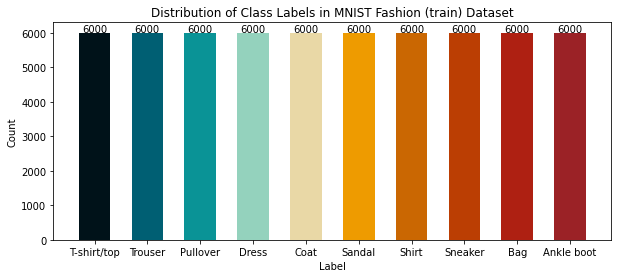

In [16]:
# plotting label distributions for training data
plot_label_distributions(train_df['LABEL'].tolist(), 'MNIST Fashion (train)', labels)

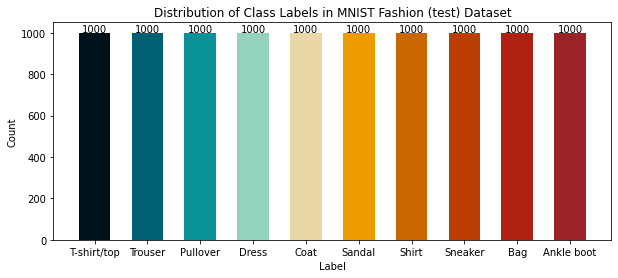

In [17]:
# plotting label distributions for testing data
plot_label_distributions(test_df['LABEL'].tolist(), 'MNIST Fashion (test)', labels)

# Implementing models

## Helper functions

## Layers

In [18]:
class NeuralNetLayer:
  def __init__(self):
    self.gradient = None
    self.parameters = None
        
  def forward(self, x):
    raise NotImplementedError

  def backward(self, gradient):
    raise NotImplementedError

In [19]:
class LinearLayer(NeuralNetLayer):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.ni = input_size
    self.no = output_size

    sigma = 0.1
    self.w = sigma * random_state.randn(output_size, input_size)
    self.b = sigma * random_state.randn(output_size)
    self.cur_input = None
    self.parameters = [self.w, self.b]

  # x is the data inputted into this layer during predictions;
  # unless this is the input layer, x is the original data inputted
  # into the model, but transformed by the preceding layers
  def forward(self, x):
    self.cur_input = x
    return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

  def backward(self, gradient):
    assert self.cur_input is not None, "Must call forward before backward"
    #dw = gradient.dot(self.cur_input)
    dw = gradient[:, :, None] @ self.cur_input[:, None, :]
    db = gradient
    self.gradient = [dw, db]
    return gradient.dot(self.w)

In [20]:
class ReLULayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = np.where(x > 0, 1.0, 0.0)

    activated_x = np.maximum(0, x)
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [21]:
class LeakyReLULayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = np.where(x > 0, 1.0, 0.01)

    # activated_x = [[float(element) if element > 0 else float(element) * 0.01 for element in sublist] for sublist in x]
    activated_x = np.maximum(0.01 * x, x)
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [22]:
class TanhLayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = 1 - (np.tanh(x) ** 2)

    activated_x = np.tanh(x)
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [23]:
class SoftmaxOutputLayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
    self.cur_probs = None

  def forward(self, x):
    exps = np.exp(x)
    probs = exps / np.sum(exps, axis=-1)[:, None]
    self.cur_probs = probs
    return probs

  def backward(self, target):
    assert self.cur_probs is not None, "Must call forward before backward"
    return self.cur_probs - target

## MLP

In [30]:
class MLP:
  def __init__(self, n_features, n_output, hidden_layers = 0, hidden_units = [0], activation_func = "None"):
    layers_list = []

    # adds the input layer
    if hidden_layers == 0:
      layers_list.append(LinearLayer(n_features, n_output))
    else:
      layers_list.append(LinearLayer(n_features, hidden_units[0]))

    # adds the hidden layers
    for i in range(hidden_layers):

      # adds activation function layers
      if activation_func.upper() == "RELU":
        layers_list.append(ReLULayer())
      elif activation_func.upper() == "TANH":
        layers_list.append(TanhLayer())
      elif activation_func.upper() == "LEAKY RELU":
        layers_list.append(LeakyReLULayer())

      # if this is the last hidden layer, it outputs the output size
      if i == hidden_layers - 1:
        layers_list.append(LinearLayer(hidden_units[i], n_output))
        continue
          
      # if this is not the last hidden layer, it outputs the hidden size
      layers_list.append(LinearLayer(hidden_units[i], hidden_units[i + 1]))
          
    # adds the output layer
    layers_list.append(SoftmaxOutputLayer())

    self.layers = layers_list

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, target):
    for layer in self.layers[::-1]:
      target = layer.backward(target)

  '''
  def fit_bad(self, x_train, y_train, opt, gd_steps, lambda_reg = 0):
    labels_count = len(set(y_train))

    losses = []
    labels = np.eye(labels_count)[np.array(y_train)]

    divider = 6000

    for _ in range(gd_steps):
      # batching (but randomly... we can fix how data is split later)
      indices = random_state.choice(len(x_train), int(len(x_train)/divider))
      batch = x_train[indices]
      batch_labels = labels[indices]
      prediction_probs = self.forward(batch)

      reg_term = lambda_reg
      if lambda_reg != 0:
        weights_sum = 0

        for layer in self.layers[::-1]:
          if type(layer).__name__ == "LinearLayer":
            weights_squared = layer.w ** 2
            weights_sum += sum(sum(weights_squared))

        reg_term = (lambda_reg * weights_sum)

      loss = -(batch_labels * np.log(prediction_probs)).sum(axis=-1).mean() + reg_term
      losses.append(loss)
      self.backward(batch_labels)
      opt.step()

    return losses
  '''

  def fit(self, x_train, y_train, x_test, y_test, opt, gd_steps, lambda_reg = 0, track_accuracy = False):
    # shuffles the data
    df = pd.DataFrame(x_train)
    df['label'] = y_train
    df_shuf = df.copy().sample(frac = 1, random_state = 1)
    x_train_shuf, y_train_shuf = x_y_from_df(df_shuf)
    
    # one-hot encodes the labels
    labels_count = len(set(y_train))
    labels = np.eye(labels_count)[np.array(y_train_shuf)]

    # the number of instances in each batch
    batch_size = int(len(x_train) / gd_steps)

    # empty lists to which we append the calculated CE loss, training accuracy and test accuracy
    losses = []
    train_accs = []
    test_accs = []

    # the index at which the current batch starts (updated in the for loop)
    start_index = 0

    # updating the model weights for each batch of training data
    for i in range(gd_steps):

      # the index at which the current batch ends
      end_index = batch_size * (i + 1)
      if(i == gd_steps - 1):
        # if this is the last batch, take all the training data from start_index to -1
        end_index = -1

      # isolates the current batch of training data and associated labels
      batch = x_train_shuf[start_index : end_index]
      batch_labels = labels[start_index : end_index]

      # updates the start index for the next batch (next iteration in the for loop)
      start_index = end_index

      # calculates the class predictions
      prediction_probs = self.forward(batch)

      ### adds regularization term (0 by default)
      reg_term = lambda_reg
      if lambda_reg != 0:
        weights_sum = 0

        # iterates through the layers in the model and adds the weights
        for layer in self.layers[::-1]:
          # if the layer is a LinearLayer, it has weights
          if type(layer).__name__ == "LinearLayer":
            weights_squared = layer.w ** 2
            weights_sum += sum(sum(weights_squared))

        reg_term = (lambda_reg * weights_sum)

      ### calculates the loss, adds it to the losses list, and back propagates based on the loss
      loss = -(batch_labels * np.log(prediction_probs)).sum(axis=-1).mean() + reg_term
      losses.append(loss)
      self.backward(batch_labels)
      opt.step()

      ### calculates the training and testing accuracy
      if track_accuracy:
        # calculates the predicted labels using the current model weights
        train_pred = self.predict(x_train)
        test_pred = self.predict(x_test)

        # evaluates the training and testing accuracy
        train_acc = evaluate_acc(train_pred, y_train)
        test_acc = evaluate_acc(test_pred, y_test)

        # appends the training and testing accuracy to the lists to return
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    # returns the CE loss, training accuracy, and testing accuracy as a function
    # of each epoch
    return losses, train_accs, test_accs

  def predict(self, x):
    pred_prob = self.forward(x)
    predictions = np.argmax(pred_prob, axis = -1)
    return predictions

In [25]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

# Running experiments

### Helper functions

In [26]:
def evaluate_acc(true_labels, target_labels):
  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances divided
  # by the total number of instances
  accuracy = np.sum(target_labels == true_labels) / label_count

  return accuracy

In [27]:
def train_and_evaluate(x_train, y_train, x_test, y_test, hidden_layers, hidden_units, activation_func, lr, gd_steps, track_loss = False, track_acc = False, lambda_reg = 0):
  n_features = x_train.shape[-1]
  n_output = len(set(y_train))

  # creates the mlp and optimizer objects
  mlp = MLP(n_features, n_output, hidden_layers, hidden_units, activation_func)
  opt = GradientDescentOptimizer(mlp, lr)

  losses, train_accs, test_accs = mlp.fit(x_train, y_train, x_test, y_test, opt, gd_steps, lambda_reg, track_acc)

  # the number of hidden layers
  hidden_layer_count = int((len(mlp.layers) - 2) / 2)

  ### plotting the cross-entropy loss
  if track_loss:
    plt.plot(losses)

    # changing the title based on whether there are hidden layers
    if hidden_layer_count == 0:
      plt.title("Cross-entropy training loss for " + str(hidden_layer_count) + " hidden layers")
    else:
      plt.title("Cross-entropy training loss for " + str(hidden_layer_count) + " hidden layer(s) with " + activation_func)
    
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy loss")

  ### plotting the training and testing accuracy
  if track_acc:
    plt.plot(train_accs, label = "Training accuracy")
    plt.plot(test_accs, label = "Testing accuracy")

    # changing the title based on whether there are hidden layers
    if hidden_layer_count == 0:
      plt.title("Training and testing accuracy for " + str(hidden_layer_count) + " hidden layers")
    else:
      plt.title("Training and testing accuracy for " + str(hidden_layer_count) + " hidden layer(s) with " + activation_func)
    
    plt.xlabel("Epoch")
    plt.ylabel("Classification accuracy")
    plt.legend()

  return mlp

In [28]:
def evaluate_mlp_acc(mlp: MLP, x_train, y_train, x_test, y_test, silent = True):
  train_predictions = mlp.predict(x_train)
  test_predictions = mlp.predict(x_test)
  
  train_acc = evaluate_acc(train_predictions, y_train)
  test_acc = evaluate_acc(test_predictions, y_test)
  
  if not silent:
    print("The accuracy of the model on the training data: " + str(round((train_acc * 100), 2)) + "%")
    print("The accuracy of the model on the testing data: " + str(round((test_acc * 100), 2)) + "%")
    print("\n")

  return train_acc, test_acc
                     

### Baseline accuracy tests



The accuracy of the model on the training data: 80.84%
The accuracy of the model on the testing data: 79.61%




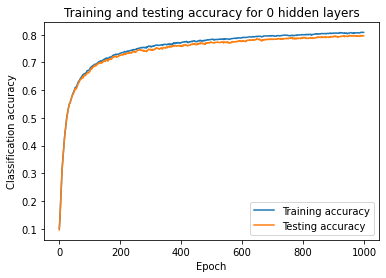

In [31]:
### plotting training and testing accuracy for 0 hidden layers (ReLU)

mlp0 = train_and_evaluate(x_train, y_train, x_test, y_test, 0, [], "ReLU", 0.01, 1000, track_acc = True)
acc0 = evaluate_mlp_acc(mlp0, x_train, y_train, x_test, y_test, silent = False)

The accuracy of the model on the training data: 80.5%
The accuracy of the model on the testing data: 79.5%




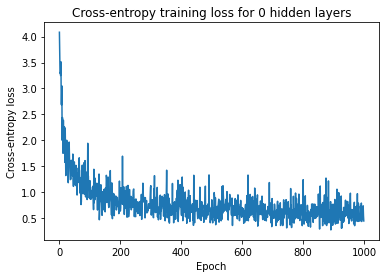

In [32]:
### plotting loss for 0 hidden layers (ReLU)

mlp0 = train_and_evaluate(x_train, y_train, x_test, y_test, 0, [], "ReLU", 0.01, 1000, track_loss = True)
acc0 = evaluate_mlp_acc(mlp0, x_train, y_train, x_test, y_test, silent = False)

The accuracy of the model on the training data: 79.99%
The accuracy of the model on the testing data: 78.98%




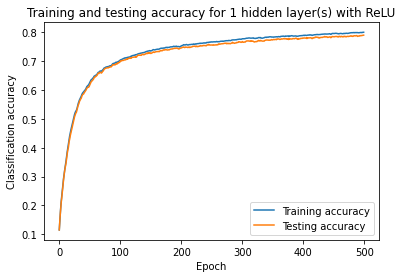

In [ ]:
### plotting training and testing accuracy for 1 hidden layer (ReLU)

mlp1 = train_and_evaluate(x_train, y_train, x_test, y_test, 1, [128], "ReLU", 0.01, 500, track_acc = True)
acc1 = evaluate_mlp_acc(mlp1, x_train, y_train, x_test, y_test, silent = False)

The accuracy of the model on the training data: 82.8%
The accuracy of the model on the testing data: 81.76%




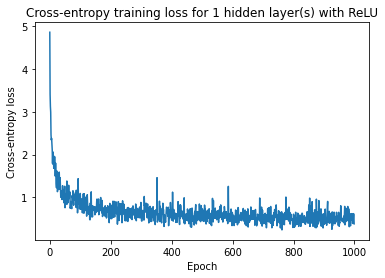

In [ ]:
### plotting loss for 1 hidden layer (ReLU)

mlp1 = train_and_evaluate(x_train, y_train, x_test, y_test, 1, [128], "ReLU", 0.01, 1000, track_loss = True)
acc1 = evaluate_mlp_acc(mlp1, x_train, y_train, x_test, y_test, silent = False)

The accuracy of the model on the training data: 76.61%
The accuracy of the model on the testing data: 76.02%




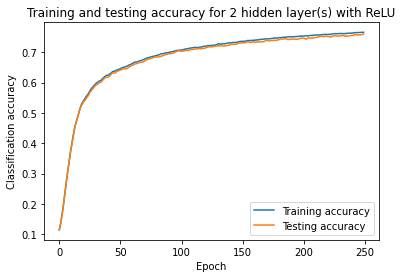

In [ ]:
### plotting training and testing accuracy for 2 hidden layers (ReLU)

mlp2 = train_and_evaluate(x_train, y_train, x_test, y_test, 2, [128, 128], "ReLU", 0.01, 250, track_acc = True)
acc2 = evaluate_mlp_acc(mlp2, x_train, y_train, x_test, y_test, silent = False)

The accuracy of the model on the training data: 82.4%
The accuracy of the model on the testing data: 81.32%




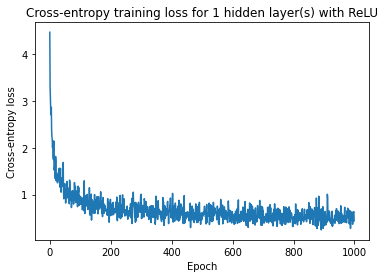

In [ ]:
### plotting loss for 2 hidden layers (ReLU)

mlp2 = train_and_evaluate(x_train, y_train, x_test, y_test, 1, [128], "ReLU", 0.01, 1000, track_loss = True)
acc2 = evaluate_mlp_acc(mlp2, x_train, y_train, x_test, y_test, silent = False)

### Testing activation functions other than ReLU

The accuracy of the model on the training data: 80.79%
The accuracy of the model on the testing data: 79.77%




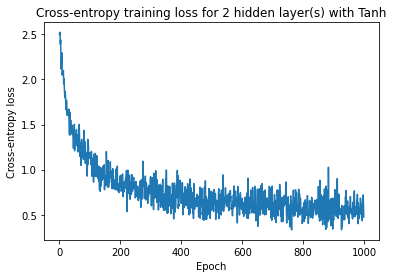

In [ ]:
### training and testing 2 hidden layers with Tanh activation functions

mlp2t = train_and_evaluate(x_train, y_train, x_test, y_test, 2, [128, 128], "Tanh", 0.01, 1000, track_loss = True)
acc2t = evaluate_mlp_acc(mlp2t, x_train, y_train, x_test, y_test, silent = False)

The accuracy of the model on the training data: 82.32%
The accuracy of the model on the testing data: 81.3%




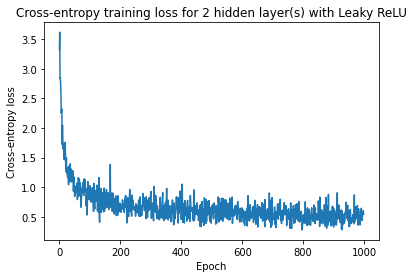

In [ ]:
### training and testing 2 hidden layers with leaky ReLU activation functions

mlp2l = train_and_evaluate(x_train, y_train, x_test, y_test, 2, [128, 128], "Leaky ReLU", 0.01, 1000, track_loss = True)
acc2l = evaluate_mlp_acc(mlp2l, x_train, y_train, x_test, y_test, silent = False)

### Adding L2 regularization

The accuracy of the model on the training data: 82.42%
The accuracy of the model on the testing data: 80.85%




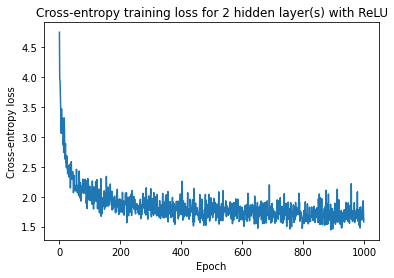

In [ ]:
### training and testing 2 hidden layers with ReLU activation functions and L2 regularization

mlp2reg = train_and_evaluate(x_train, y_train, x_test, y_test, 2, [128, 128], "ReLU", 0.01, 1000, track_loss = True, lambda_reg = 0.001)
acc2reg = evaluate_mlp_acc(mlp2reg, x_train, y_train, x_test, y_test, silent = False)

## Using a model trained on unnormalized images

The accuracy of the model on the training data: 73.9%
The accuracy of the model on the testing data: 72.79%




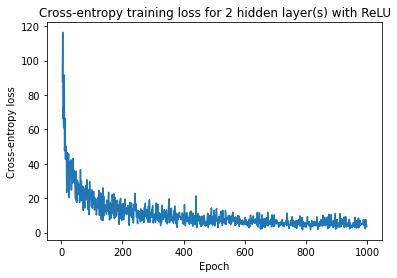

In [ ]:
### training and testing 2 hidden layers with ReLu activation functions

mlp2ln = train_and_evaluate(x_train_unprocessed, y_train, x_test_unprocessed, y_test, 2, [128, 128], "ReLU", 0.0001, 1000, track_loss = True)
acc2ln = evaluate_mlp_acc(mlp2ln, x_train_unprocessed, y_train, x_test_unprocessed, y_test, silent = False)